##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Showcasing Agile Safety Classifiers with Gemma

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/agile_classifiers"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/agile_classifiers.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/agile_classifiers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://codelabs.developers.google.com/codelabs/responsible-ai/agile-classifiers"><img src="https://www.tensorflow.org/images/codelabs_logo.png" height="24" width="48"/>Learn in Codelabs</a>
  </td>
</table>

This codelab illustrates how to create a customised text classifier using
parameter efficient tuning (PET). Instead of fine-tuning the whole model, PET
methods update only a small amount of parameters, which makes it relatively easy
and fast to train. It also makes it easier for a model to learn new behaviors
with relatively little training data. The methodology is described in detail in
[*Towards Agile Text Classifiers for Everyone*][paper-agile-classifiers] which
shows how these techniques can be applied to a variety of safety tasks and
achieve state of the art performance with only a few hundred training examples.

This codelab uses the [LoRA](https://arxiv.org/abs/2106.09685) PET method and
the smaller Gemma model (`gemma_instruct_2b_en`) since that can be run faster
and more efficiently. The colab covers the steps of ingesting data, formatting
it for the LLM, training LoRA weights, and then evaluating the results. This
codelab trains on the [ETHOS dataset][ethos-dataset], a publicly available
dataset for detecting hateful speech, built from YouTube and Reddit comments.
When trained on only 200 examples (1/4 of the dataset) it achieves F1: 0.80 and
ROC-AUC: 0.78, slightly above the SOTA currently reported on
[the leaderboard][ethos-leaderboard] (at the time of writing, 15 Feb 2024). When
trained on the full 800 examples, like it achieves an F1 score of 83.74 and a
ROC-AUC score of 88.17. Larger models, like `gemma_instruct_7b_en` will
generally perform better, but training and execution costs are also larger.

**Trigger Warning**: because this codelab develops a safety classifier for
detecting hateful speech, examples and evaluation of the results contains some
horrible language.

[paper-agile-classifiers]: https://arxiv.org/abs/2302.06541
[ethos-dataset]: https://arxiv.org/abs/2006.08328
[ethos-leaderboard]: https://paperswithcode.com/sota/hate-speech-detection-on-ethos-binary


## Installation and Setup

For this codelab, you will need a recent version `keras` (3), `keras-nlp`
(0.8.0) and a Kaggle account to download the base model.

In [ ]:
import kagglehub

kagglehub.login()

In [ ]:
!pip install -q -U keras-nlp
!pip install -q -U keras

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

## Load ETHOS dataset

In this section you will load the dataset on which to train our classifier and
preprocess it into a train and test set. You will use the popular research
dataset ETHOS which was collected to detect hate speech in social media. You
can find more information about how the dataset was collected in the paper
[ETHOS: an Online Hate Speech Detection Dataset][ethos-dataset].

In [ ]:
import pandas as pd

gh_root = 'https://raw.githubusercontent.com'
gh_repo = 'intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset'
gh_path = 'master/ethos/ethos_data/Ethos_Dataset_Binary.csv'
data_url = f'{gh_root}/{gh_repo}/{gh_path}'

df = pd.read_csv(data_url, delimiter=';')
df['hateful'] = (df['isHate'] >= df['isHate'].median()).astype(int)

# Shuffle the dataset.
df = df.sample(frac=1, random_state=32)

# Split into train and test.
df_train, df_test = df[:800],  df[800:]

# Display a sample of the data.
df.head(5)[['hateful', 'comment']]

,hateful,comment
517,0,You said he but still not convinced this is a ...
685,0,"well, looks like its time to have another child"
706,0,to be honest I am part of the LGBT community a...
182,1,What if we send every men to mars to start a n...
829,0,"It doesn't matter if you're black or white, ..."


## Download and Instantiate the Model

As described in [the documentation](//ai.google.dev/gem/docs), you can easily
use the Gemma model in many ways. With Keras, this is what you need to do:

In [ ]:
import keras
import keras_nlp

# For reproducibility purposes.
keras.utils.set_random_seed(1234)

# Download the model from Kaggle using Keras.
model = keras_nlp.models.GemmaCausalLM.from_preset('gemma_instruct_2b_en')

# Set the sequence length to a small enough value to fit in memory in Colab.
model.preprocessor.sequence_length = 128

In [ ]:
model.generate('Question: what is the capital of France? ', max_length=32)

## Text Preprocessing and Separator Tokens

To help the model understand our intent better, you can preprocess the text and
use separator tokens. This makes it less likely for the model to generate text
that does not fit the expected format. For example, you might attempt to request
a sentiment classification from the model by writing a prompt like this:

```console
Classify the following text into one of the following classes:[Positive,Negative]

Text: you look very nice today
Classification:
```

In this case, the model may or may not output what you are looking for. For
example, if the text contains newline characters, it's likely to have a negative
effect on the model performance. A more robust approach is to use separator
tokens. The prompt then becomes:

```console
Classify the following text into one of the following classes:[Positive,Negative]
<separator>
Text: you look very nice today
<separator>
Prediction:
```

This can be abstracted using a function that preprocesses the text:


In [ ]:
def preprocess_text(
    text: str,
    labels: list[str],
    instructions: str,
    separator: str,
) -> str:
  prompt = f'{instructions}:[{",".join(labels)}]'
  return separator.join([prompt, f'Text:{text}', 'Prediction:'])

Now, if you run the function using the same prompt and text as before, you
should get the same output:

In [ ]:
text = 'you look very nice today'

prompt = preprocess_text(
    text=text,
    labels=['Positive', 'Negative'],
    instructions='Classify the following text into one of the following classes',
    separator='\n<separator>\n',
)

print(prompt)

Classify the following text into one of the following classes:[Positive,Negative]
<separator>
Text:you look very nice today
<separator>
Prediction:


## Output Postprocessing

The outputs of the model are tokens with various probabilities. Normally, to
generate text, you would select among the top few most probable tokens and
construct sentences, paragraphs or even full documents. However, for the purpose
of classification, what actually matters is whether the model believes that
`Positive` is more probable than `Negative` or vice versa.

Given the model you instantiated earlier, this is how you can process its output
into the independent probabilities of whether the next token is `Positive` or
`Negative`, respectively:

In [ ]:
import numpy as np


def softmax_normalization(arr: np.ndarray) -> np.ndarray:
  """Normalizes logits values into probabilities summing to one."""
  arr_exp = np.exp(arr - np.max(arr))
  return arr_exp / arr_exp.sum()


def compute_token_probability(
    model: keras_nlp.models.GemmaCausalLM,
    prompt: str,
    target_tokens: list[str],
) -> dict[str, float]:
  # Shorthands.
  preprocessor = model.preprocessor
  tokenizer = preprocessor.tokenizer

  # Identify output token offset.
  (padding_mask,) = preprocessor.generate_preprocess([prompt])['padding_mask']
  token_offset = sum(padding_mask.numpy()) - 1

  # Compute prediction, extract only the next token's logits.
  (logits,) = model.predict([prompt], verbose=0)
  token_logits = logits[token_offset]

  # Identify the token indices, which is the same as the ID for this tokenizer.
  # NOTE: If a token is not found, it will be considered same as "<unk>".
  token_ids = [tokenizer.token_to_id(token) for token in target_tokens]

  # Compute the relative probability of each of the requested tokens.
  probabilities = softmax_normalization([token_logits[ix] for ix in token_ids])

  return dict(zip(target_tokens, probabilities))

You can test that function by running it with a the prompt you created earlier:

In [ ]:
compute_token_probability(
    model=model,
    prompt=prompt,
    target_tokens=['Positive', 'Negative'],
)

{'Positive': 0.99994016, 'Negative': 5.984089e-05}

## Wrapping it all as a Classifier

For ease of use, you can wrap all of the functions you just created into a
single sklearn-like classifier with easy to use and familiar functions like
`predict()` and `predict_score()`.

In [ ]:
import dataclasses


@dataclasses.dataclass(frozen=True)
class AgileClassifier:
  """Agile classifier to be wrapped around a LLM."""

  # The classes whose probability will be predicted.
  labels: tuple

  # Provide default instructions and control tokens, can be overridden by user.
  instructions: str = 'Classify the following text into one of the following classes'
  separator_token: str = '<separator>'
  end_of_text_token: str = '<eos>'

  def encode_for_prediction(self, x_text: str) -> str:
    return preprocess_text(
        text=x_text,
        labels=self.labels,
        instructions=self.instructions,
        separator=self.separator_token,
    )

  def encode_for_training(self, x_text: str, y: int) -> str:
    return ''.join([
        self.encode_for_prediction(x_text),
        self.labels[y],
        self.end_of_text_token,
    ])

  def predict_score(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_text: str,
  ) -> list[float]:
    prompt = self.encode_for_prediction(x_text)
    token_probabilities = compute_token_probability(
        model=model,
        prompt=prompt,
        target_tokens=self.labels,
    )
    return [token_probabilities[token] for token in self.labels]

  def predict(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_eval: str,
  ) -> int:
    return np.argmax(self.predict_score(model, x_eval))

agile_classifier = AgileClassifier(labels=('Positive', 'Negative'))

## Model Fine-Tuning

LoRA stands for Low-Rank Adaptation. It's a fine-tuning technique that can be
used to efficiently fine-tune large language models. You can read more about it
in the [*LoRA: Low-Rank Adaptation of Large Language Models* paper][paper-lora].

The Keras implementation of Gemma provides a `enable_lora()` method that you can
use for fine-tuning:

[paper-lora]: https://arxiv.org/abs/2106.09685

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
model.backbone.enable_lora(rank=4)

After enabling LoRA, you can start the fine-tuning process. This takes approximately 5 minutes per epoch on Colab:

In [ ]:
import tensorflow as tf

# Create dataset with preprocessed text + labels.
map_fn = lambda x: agile_classifier.encode_for_training(*x)
x_train = list(map(map_fn, df_train[['comment', 'hateful']].values))
ds_train = tf.data.Dataset.from_tensor_slices(x_train).batch(2)

# Compile the model using the Adam optimizer and appropriate loss function.
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Begin training.
model.fit(ds_train, epochs=4)

Epoch 1/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 354s 703ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.5874
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 338s 716ms/step - loss: 0.7579 - sparse_categorical_accuracy: 0.6662
Epoch 3/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 324s 721ms/step - loss: 0.6818 - sparse_categorical_accuracy: 0.6894
Epoch 4/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 323s 725ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7220


Training for more epochs will result in higher accuracy, until overfitting
occurs.

## Inspect the Results

You can now inspect the output of the agile classifier you just trained. This
code will output the predicted class score given a piece of text:

In [ ]:
text = 'you look really nice today'
scores = agile_classifier.predict_score(model, text)
dict(zip(agile_classifier.labels, scores))

{'Positive': 0.99899644, 'Negative': 0.0010035498}

## Model Evaluation

Finally, you'll evaluate the performance of our model using two common metrics,
the [F1 score][f1-score] and the [AUC-ROC][auc-roc]. The F1 score captures false
negative and false positive errors by evaluating the harmonic mean of the
precision and recall at a certain classification threshold. The AUC-ROC on the
other hand captures the tradeoff between the true positive rate and the false
positive rate across a variety of thresholds and computes the area under this
curve.

[f1-score]: https://en.wikipedia.org/wiki/F-score
[auc-roc]: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [ ]:
y_true = df_test['hateful'].values
# Compute the scores (aka probabilities) for each of the labels.
y_score = [agile_classifier.predict_score(model, x) for x in df_test['comment']]
# The label with highest score is considered the predicted class.
y_pred = np.argmax(y_score, axis=1)
# Extract the probability of a comment being considered hateful.
y_prob = [x[agile_classifier.labels.index('Negative')] for x in y_score]

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

print(f'F1: {f1_score(y_true, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_true, y_prob):.2f}')

F1: 0.84
AUC-ROC: 0.88


Another interesting way to evaluate model predictions are confusion matrices. A
confusion matrix will visually depict the different kinds of prediction errors.

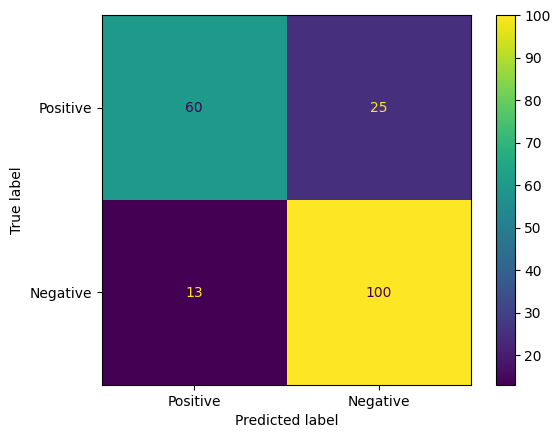

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=agile_classifier.labels,
).plot()

Finally, you can also look at the ROC curve to get a sense of potential
prediction errors with using different scoring thresholds.

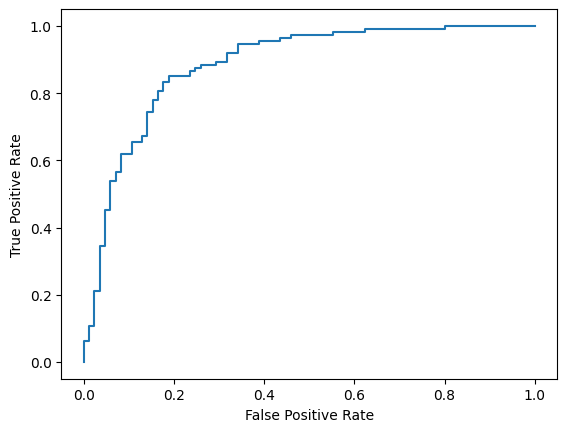

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Appendix

We have done some basic exploration of the hyper-parameter space to help get a better sense of the relationship between the dataset size and the performance. See the following plot.

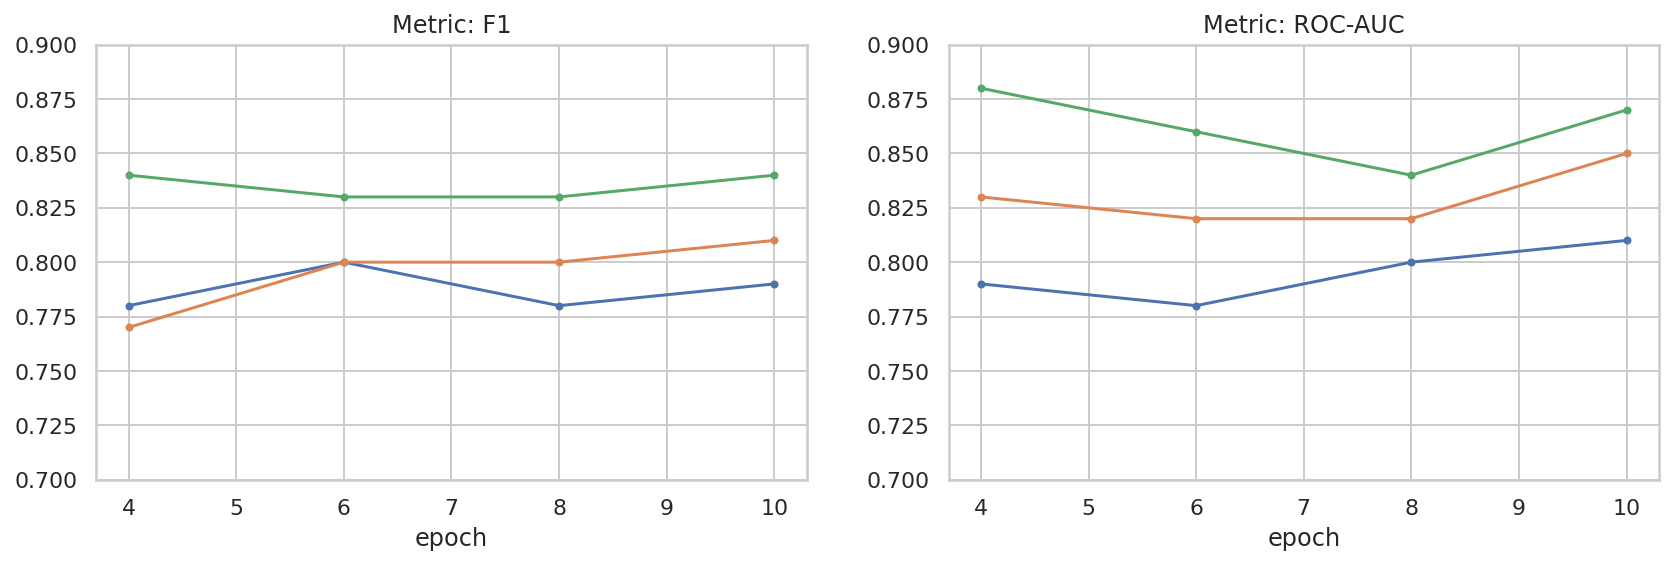

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

results_f1 = pd.DataFrame([
    {'training_size': 800, 'epoch': 4, 'metric': 'f1', 'score': 0.84},
    {'training_size': 800, 'epoch': 6, 'metric': 'f1', 'score': 0.83},
    {'training_size': 800, 'epoch': 8, 'metric': 'f1', 'score': 0.83},
    {'training_size': 800, 'epoch': 10, 'metric': 'f1', 'score': 0.84},
    {'training_size': 400, 'epoch': 4, 'metric': 'f1', 'score': 0.77},
    {'training_size': 400, 'epoch': 6, 'metric': 'f1', 'score': 0.80},
    {'training_size': 400, 'epoch': 8, 'metric': 'f1', 'score': 0.80},
    {'training_size': 400, 'epoch': 10,'metric': 'f1', 'score': 0.81},
    {'training_size': 200, 'epoch': 4, 'metric': 'f1', 'score': 0.78},
    {'training_size': 200, 'epoch': 6, 'metric': 'f1', 'score': 0.80},
    {'training_size': 200, 'epoch': 8, 'metric': 'f1', 'score': 0.78},
    {'training_size': 200, 'epoch': 10, 'metric': 'f1', 'score': 0.79},
])

results_roc_auc = pd.DataFrame([
    {'training_size': 800, 'epoch': 4, 'metric': 'roc-auc', 'score': 0.88},
    {'training_size': 800, 'epoch': 6, 'metric': 'roc-auc', 'score': 0.86},
    {'training_size': 800, 'epoch': 8, 'metric': 'roc-auc', 'score': 0.84},
    {'training_size': 800, 'epoch': 10, 'metric': 'roc-auc', 'score': 0.87},
    {'training_size': 400, 'epoch': 4, 'metric': 'roc-auc', 'score': 0.83},
    {'training_size': 400, 'epoch': 6, 'metric': 'roc-auc', 'score': 0.82},
    {'training_size': 400, 'epoch': 8, 'metric': 'roc-auc', 'score': 0.82},
    {'training_size': 400, 'epoch': 10,'metric': 'roc-auc', 'score': 0.85},
    {'training_size': 200, 'epoch': 4, 'metric': 'roc-auc', 'score': 0.79},
    {'training_size': 200, 'epoch': 6, 'metric': 'roc-auc', 'score': 0.78},
    {'training_size': 200, 'epoch': 8, 'metric': 'roc-auc', 'score': 0.80},
    {'training_size': 200, 'epoch': 10, 'metric': 'roc-auc', 'score': 0.81},
])


plot_opts = dict(style='.-', ylim=(0.7, 0.9))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
process_results_df = lambda df: df.set_index('epoch').groupby('training_size')['score']
process_results_df(results_f1).plot(title='Metric: F1', ax=ax1, **plot_opts)
process_results_df(results_roc_auc).plot(title='Metric: ROC-AUC', ax=ax2, **plot_opts)
fig.show()